# Predicting Access to Higher Education
By: Yarden, Brandon, and Tommy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report, precision_score
import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
import gc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/BSAN 6070 Final Project/Sample ACS 2021 for LMU.csv', encoding='latin1')

<ipython-input-3-eff4e5cb8f12>:1: DtypeWarning: Columns (5,15,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/BSAN 6070 Final Project/Sample ACS 2021 for LMU.csv', encoding='latin1')


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Quality Analysis

First we start with a data quality analysis to get a first look at our data and understand what needs to be cleaned.

In [5]:
df.head(10)

,REGION,STATEFIP,PERWT,NCHILD,SEX,AGE,MARST,MARRNO,RACE,RACED,BPL,BPLD,ANCESTR1,ANCESTR1D,CITIZEN,YRNATUR,LANGUAGE,LANGUAGED,SPEAKENG,EDUC,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,EMPSTATD,CLASSWKR,CLASSWKRD,OCCSOC,IND,WKSWORK1,UHRSWORK,INCTOT,INCWAGE,INCINVST,INCOTHER,INCEARN,TRANWORK,TRANTIME,DEPARTS,ARRIVES
0,East South Central Div.,Alabama,48.0,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",NaN,NaN,English,English,"Yes, speaks only English",1 year of college,"1 or more years of college credit, no degree",NaN,NaN,NaN,NaN,Employed,At work,Works for wages,"Wage/salary, private",399041,7870,52,40,6300,6300,0,0,6300,"Auto, truck, or van",5,1915,1909
1,East South Central Div.,Alabama,9.0,0 children present,Female,52,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",NaN,NaN,English,English,"Yes, speaks only English",Grade 12,Regular high school diploma,NaN,NaN,NaN,NaN,Employed,At work,Works for wages,"Wage/salary, private",537051,6390,52,40,40600,40600,0,0,40600,"Auto, truck, or van",5,802,809
2,East South Central Div.,Alabama,46.0,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",NaN,NaN,English,English,"Yes, speaks only English",Grade 12,"Some college, but less than 1 year",NaN,NaN,NaN,NaN,Employed,At work,Works for wages,State govt employee,412010,5391,52,41,6000,6000,0,0,6000,"Auto, truck, or van",25,532,559
3,East South Central Div.,Alabama,54.0,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",NaN,NaN,English,English,"Yes, speaks only English",1 year of college,"1 or more years of college credit, no degree",NaN,NaN,NaN,NaN,Employed,At work,Works for wages,"Wage/salary, private",399041,7870,52,40,6300,6300,0,0,6300,"Auto, truck, or van",5,1915,1909
4,East South Central Div.,Alabama,42.0,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Florida,Florida,African-American,"African-American (1990-2000, ACS, PRCS)",NaN,NaN,English,English,"Yes, speaks only English",Grade 12,"Some college, but less than 1 year",NaN,NaN,NaN,NaN,Employed,At work,Works for wages,"Wage/salary, private",352010,8680,52,35,26400,26400,0,0,26400,Walked only,3,1455,1459
5,East South Central Div.,Alabama,61.0,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",NaN,NaN,English,English,"Yes, speaks only English",Grade 12,"Some college, but less than 1 year",NaN,NaN,NaN,NaN,Employed,At work,Works for wages,State govt employee,412010,5391,52,41,6000,6000,0,0,6000,"Auto, truck, or van",25,532,559
6,East South Central Div.,Alabama,3.0,0 children present,Male,39,Never married/single,Not Applicable,White,White,Missouri,Missouri,Not Reported,Not Reported,NaN,NaN,English,English,"Yes, speaks only English",5+ years of college,Master's degree,Theology and Religious Vocations,Theology and Religious Vocations,NaN,NaN,Employed,At work,Works for wages,Wage/salary at non-profit,212011,9160,52,70,34000,31500,2500,0,31500,Walked only,5,847,854
7,East South Central Div.,Alabama,38.0,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",NaN,NaN,English,English,"Yes, speaks only English",Grade 12,"Some college, but less than 1 year",NaN,NaN,NaN,NaN,Employed,At work,Works for wages,State govt employee,412010,5391,52,41,6000,6000,0,0,6000,"Auto

In [6]:
df.shape

(502363, 42)

In [7]:
cat_vars = df.select_dtypes(include='object')
cat_summary = pd.DataFrame({
    'Cardinality': cat_vars.nunique(),
    'Mode': cat_vars.mode().iloc[0],
    'Frequency': cat_vars.apply(lambda x: x.value_counts().iloc[0]),
    'Missing (%)': cat_vars.isnull().mean() * 100
})

In [ ]:
cat_summary

,Cardinality,Mode,Frequency,Missing (%)
REGION,9,South Atlantic Division,100188,0.000000
STATEFIP,51,California,57369,0.000000
NCHILD,10,0 children present,276522,0.000000
SEX,2,Male,281131,0.000000
AGE,158,50,10038,0.000000
MARST,6,"Married, spouse present",294029,0.000000
MARRNO,4,Married once,294310,0.000000
RACE,9,White,341672,0.000000
RACED,139,White,341672,0.000000
BPL,123,California,41016,0.000000


Large amount of missing values for DEGFIELD2, DEGFIELD2D, DEGFIELDD, DEGFIELD, YRNATUR, and CITIZEN. Will consider dropping these, especially considering the degree field columns which would present data leakage issues.

In [ ]:
cont_vars = df.select_dtypes(include=['int64', 'float64'])
cont_summary = cont_vars.describe().T
cont_summary['Missing (%)'] = cont_vars.isnull().mean() * 100

In [ ]:
cont_summary

,count,mean,std,min,25%,50%,75%,max,Missing (%)
PERWT,502363.0,107.669132,92.227745,1.0,53.0,81.0,131.0,2471.0,0.0
IND,502363.0,6175.757974,2667.678290,170.0,4580.0,7270.0,8090.0,9590.0,0.0
WKSWORK1,502363.0,51.980297,0.190678,50.0,52.0,52.0,52.0,52.0,0.0
INCTOT,502363.0,80917.390530,87420.436979,-9500.0,36000.0,58000.0,92500.0,1487400.0,0.0
INCWAGE,502363.0,73129.947046,78261.462905,0.0,33000.0,53000.0,86000.0,787000.0,0.0
INCINVST,502363.0,1772.900739,17421.416029,-6300.0,0.0,0.0,0.0,522000.0,0.0
INCOTHER,502363.0,352.587153,2869.488204,0.0,0.0,0.0,0.0,76000.0,0.0
TRANTIME,502363.0,21.224226,22.362510,0.0,5.0,15.0,30.0,163.0,0.0
DEPARTS,502363.0,627.603430,433.007743,0.0,502.0,702.0,802.0,2345.0,0.0
ARRIVES,502363.0,657.883620,442.539338,0.0,519.0,719.0,824.0,2359.0,0.0


Not too much to note from our continous variable data quality report besides the lack of missing values which makes our job a little easier. Next let's visualize these to see our outliers.

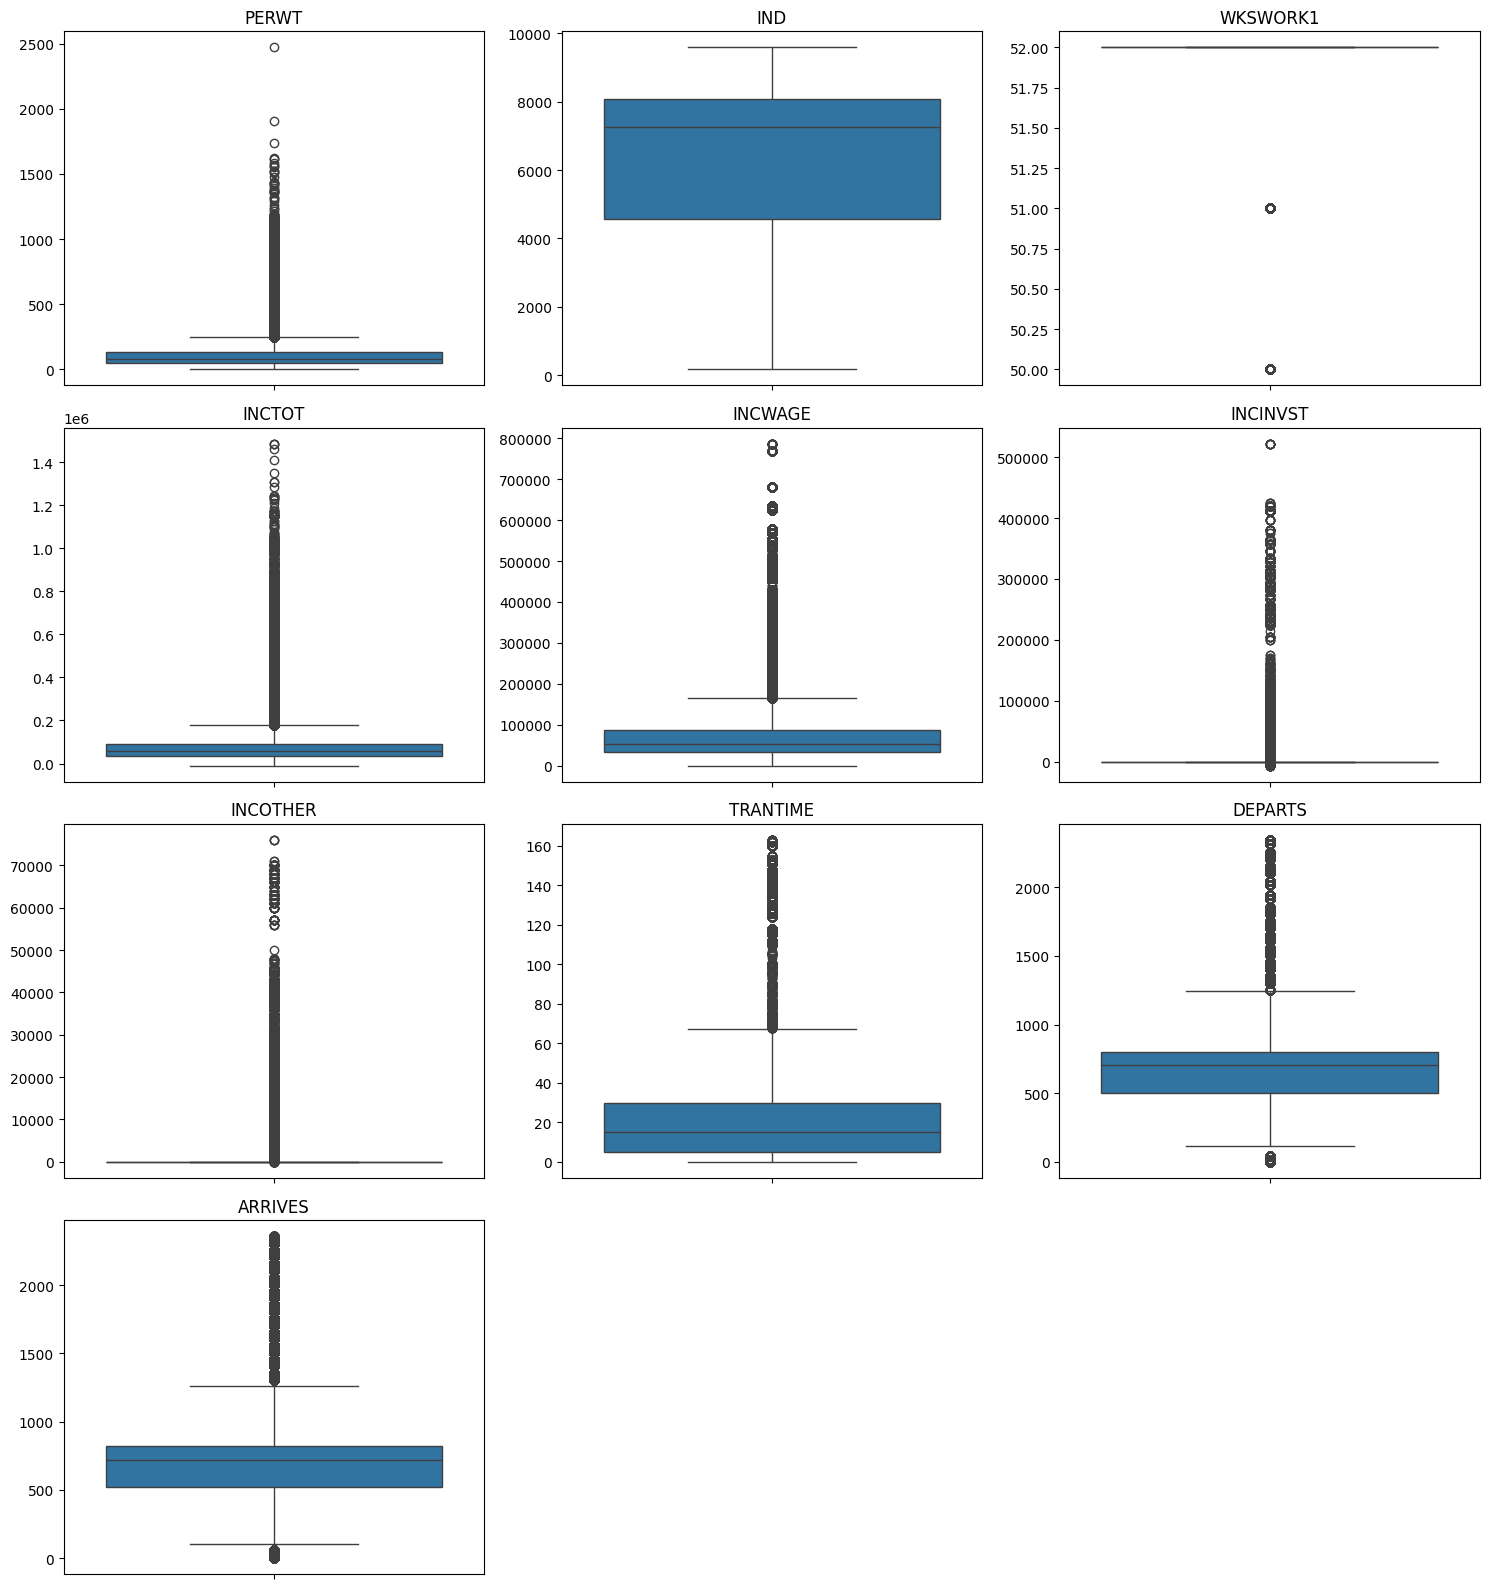

In [ ]:
# Determine grid size
n_vars = len(cont_vars.columns)
n_cols = 3  # You can adjust this number
n_rows = math.ceil(n_vars / n_cols)

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Create box plots
for i, col in enumerate(cont_vars.columns):
    sns.boxplot(y=cont_vars[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

We certainly see outliers in many of these columns. We'll wait to handle these as we will most likely end up removing many of these columns becuase of their irrelavance to our question and their potential for data leakage.

<ipython-input-11-2a61c2c096e0>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha='center')
<ipython-input-11-2a61c2c096e0>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha='center')
<ipython-input-11-2a61c2c096e0>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha='center')
<ipython-input-11-2a61c2c096e0>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha='center')
<ipython-input-11-2a61c2c096

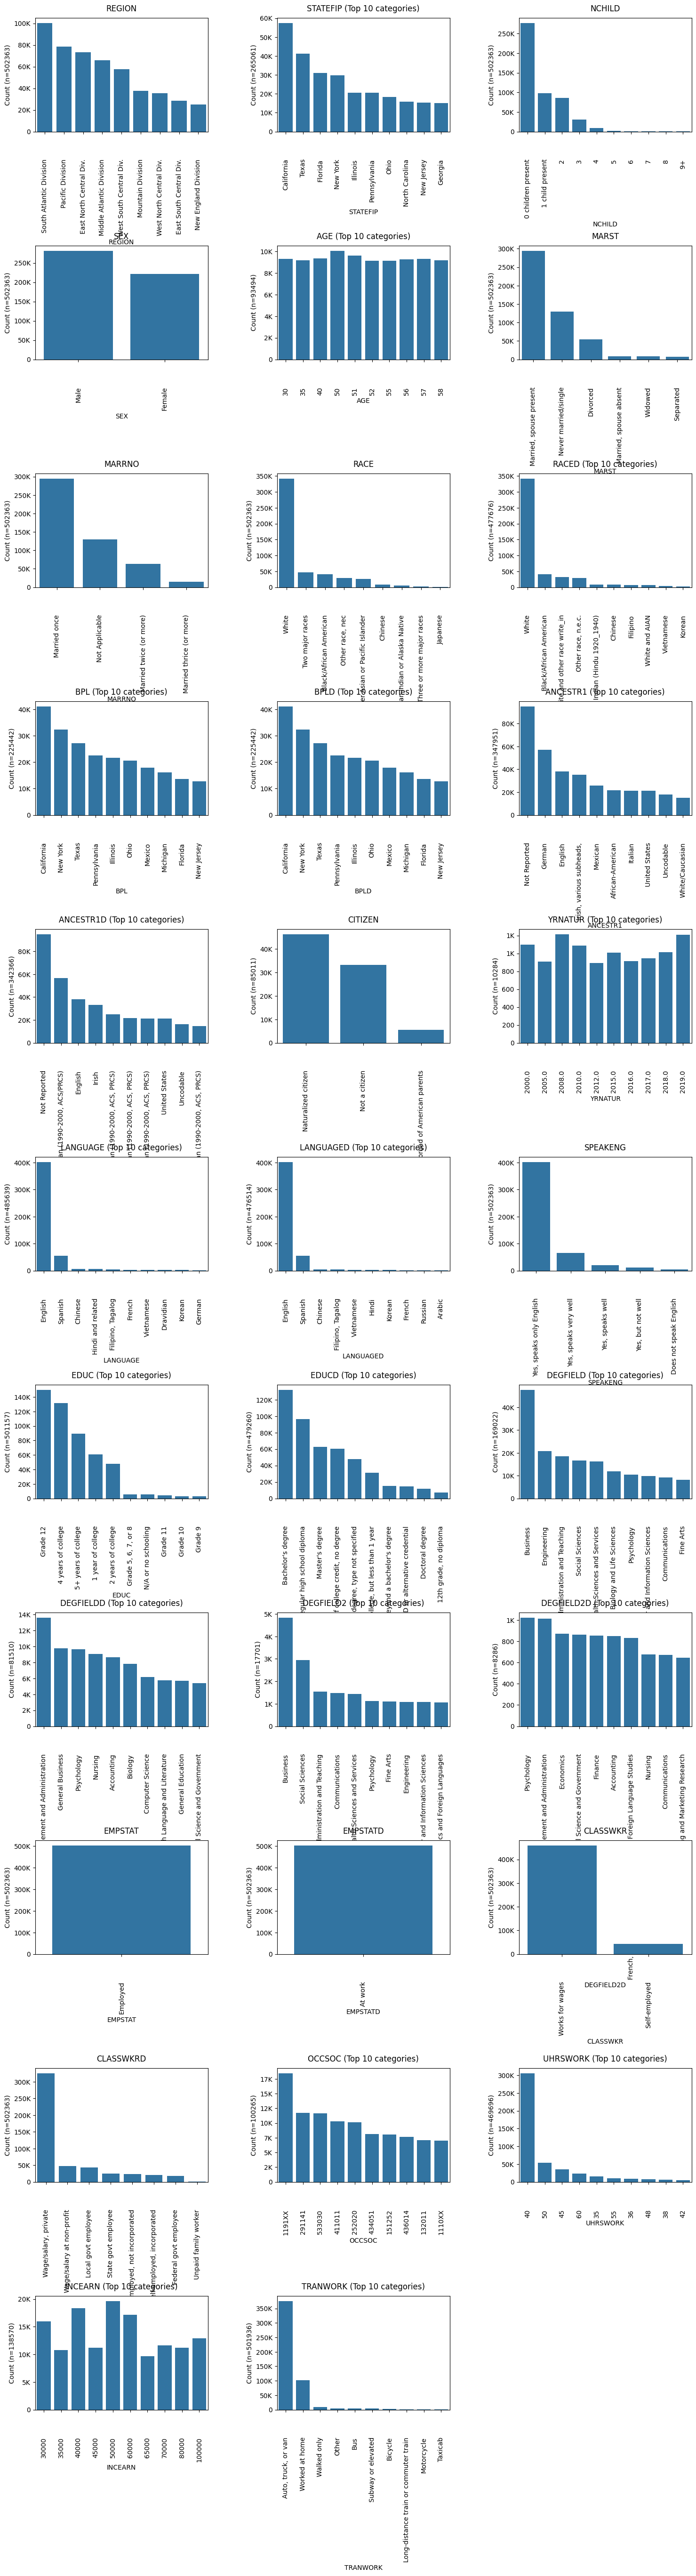

In [ ]:
# Filter categorical columns (those not in cont_vars)
cat_cols = [col for col in df.columns if col not in cont_vars.columns]

# Determine grid size
n_cats = len(cat_cols)
n_cols = 3
n_rows = math.ceil(n_cats / n_cols)

# Create figure with more height to accommodate long labels
fig = plt.figure(figsize=(18, n_rows * 6))

# Set up the subplots with explicitly defined spacing
gs = fig.add_gridspec(n_rows, n_cols, hspace=1.0, wspace=0.4)
axes = []

# Create axes with the gridspec
for i in range(n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes.append(fig.add_subplot(gs[row, col]))

# Create bar plots for each categorical variable
for i, col in enumerate(cat_cols):
    if i >= len(axes):
        break

    # Get value counts and sort by frequency
    counts = df[col].value_counts().sort_values(ascending=False)

    # For variables with many categories, limit to top 10
    if len(counts) > 10:
        counts = counts.head(10)
        title = f"{col} (Top 10 categories)"
    else:
        title = col

    # Create bar plot
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i])
    axes[i].set_title(title, fontsize=12, pad=10)

    # Rotate x-labels and set position to avoid cutting off
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha='center')

    # Format y-axis to show thousands with K
    if max(counts) > 1000:
        from matplotlib.ticker import FuncFormatter
        axes[i].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x >= 1000 else f'{int(x)}'))

    # Show category counts in the y-axis label
    axes[i].set_ylabel(f'Count (n={sum(counts)})')

    # Add bottom margin to make room for labels
    plt.setp(axes[i].get_xticklabels(), y=-0.2)

# Hide unused subplots
for j in range(len(cat_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

A couple things to note. First, region has a fairly high cardinality with some regions not containing that many people. We may consider binning this feature if we face overfitting issues. The same goes for state where we may opt for using region instead if it causes problems. The ages range quite a bit and thus will need to binned.

Let's create a function to compare some of our similar columns like RACE and RACED, BPL and BPLD, and LANGUAGE and LANGUAGED to understand how different they actually are.

In [ ]:
def compare_columns(df, col1, col2):
    # Row-wise comparison
    are_equal = df[col1] == df[col2]
    all_rows_equal = are_equal.all()

    print(f"Are all rows identical between '{col1}' and '{col2}'? {all_rows_equal}")
    print(f"Number of rows where values differ: {(~are_equal).sum()}")

    # Sample differing rows
    if not all_rows_equal:
        print("\nSample rows where values differ:")
        print(df.loc[~are_equal, [col1, col2]].head())

    # Set comparison of unique values
    values1 = set(df[col1].dropna().unique())
    values2 = set(df[col2].dropna().unique())

    print(f"\nUnique values in '{col1}': {values1}")
    print(f"Unique values in '{col2}': {values2}")
    print(f"Do they contain the same unique values? {values1 == values2}")

    if values1 != values2:
        print(f"Values in '{col1}' but not in '{col2}': {values1 - values2}")
        print(f"Values in '{col2}' but not in '{col1}': {values2 - values1}")

In [ ]:
compare_columns(df, 'RACE', 'RACED')

Are all rows identical between 'RACE' and 'RACED'? False
Number of rows where values differ: 110995

Sample rows where values differ:
               RACE                          RACED
13  Two major races                White and Black
20  Two major races  White and other race write_in
26  Other race, nec             Other race, n.e.c.
27  Other race, nec             Other race, n.e.c.
48  Two major races             White and Filipino

Unique values in 'RACE': {'Three or more major races', 'Other race, nec', 'Chinese', 'American Indian or Alaska Native', 'Two major races', 'Black/African American', 'White', 'Japanese', 'Other Asian or Pacific Islander'}
Unique values in 'RACED': {'Asian, PI, other race write_in', 'Inupiat', 'Black and Filipino', 'Other Amer. Indian tribe (2000,ACS)', 'Crow', 'Thai', 'AIAN and Asian Indian', 'White and other Asian race(s)', 'White, Filipino, Hawaiian', 'White and Black', 'Japanese and Hawaiian (2000 1%)', 'White, Black, AIAN, PI, other race write_in', 

In [ ]:
compare_columns(df, 'BPL', 'BPLD')

Are all rows identical between 'BPL' and 'BPLD'? False
Number of rows where values differ: 27174

Sample rows where values differ:
                   BPL                BPLD
144        West Indies  Dominican Republic
152    Central America         El Salvador
218      SOUTH AMERICA            Colombia
312      SOUTH AMERICA            Colombia
334  Other USSR/Russia             Ukraine

Unique values in 'BPL': {'Greece', 'District of Columbia', 'Iowa', 'Pennsylvania', 'China', 'Other USSR/Russia', 'Puerto Rico', 'Nepal', 'Guam', 'Laos', 'New Mexico', 'Austria', 'Turkey', 'Iraq', 'West Indies', 'Europe, ns', 'Vermont', 'Cuba', 'Lithuania', 'Massachusetts', 'Portugal', 'Oregon', 'England', 'Utah', 'Pacific Islands', 'New Jersey', 'Afghanistan', 'Connecticut', 'Oklahoma', 'AFRICA', 'Georgia', 'Scotland', 'Michigan', 'Hungary', 'Yemen Arab Republic (North)', 'Arkansas', 'Malaysia', 'Switzerland', 'California', 'Lebanon', 'Virginia', 'Nevada', 'Alaska', 'Americas, n.s.', 'Kansas', 'Asia, ne

In [ ]:
compare_columns(df, 'ANCESTR1', 'ANCESTR1D')

Are all rows identical between 'ANCESTR1' and 'ANCESTR1D'? False
Number of rows where values differ: 210440

Sample rows where values differ:
           ANCESTR1                                ANCESTR1D
0  African-American  African-American (1990-2000, ACS, PRCS)
1  African-American  African-American (1990-2000, ACS, PRCS)
2  African-American  African-American (1990-2000, ACS, PRCS)
3  African-American  African-American (1990-2000, ACS, PRCS)
4  African-American  African-American (1990-2000, ACS, PRCS)

Unique values in 'ANCESTR1': {'Not Reported', 'American Indian  (all tribes)', 'Iraqi', 'Alsatian, Alsace-Lorraine', 'Liberian', 'Other West Indian', 'Moldavian', 'Thai', 'European, nec', 'Guamanian', 'Somalian', 'Haitian', 'Czechoslovakian', 'Eskimo', 'German', 'Chamorro Islander', 'Spaniard', 'Basque', 'Burmese', 'Argentinean', 'Belorussian', 'Vietnamese', 'Canadian', 'Yemeni', 'Ecuadorian', 'Mexican', 'Cossack', 'Korean', 'Samoan', 'Finnish', 'Venezuelan', 'Eastern European, nec', 'I

In [ ]:
compare_columns(df, 'LANGUAGE', 'LANGUAGED')

Are all rows identical between 'LANGUAGE' and 'LANGUAGED'? False
Number of rows where values differ: 17297

Sample rows where values differ:
                   LANGUAGE LANGUAGED
62                Dravidian    Telugu
169       Hindi and related     Hindi
404  Other Persian dialects   Kurdish
405  Other Persian dialects   Kurdish
408       Hindi and related     Hindi

Unique values in 'LANGUAGE': {'Near East Arabic dialect', 'Indonesian', 'Slovak', 'Dravidian', 'Other Altaic', 'Lithuanian', 'Yiddish, Jewish', 'Polish', 'Burmese, Lisu, Lolo', 'Amharic, Ethiopian, etc.', 'Japanese', 'Arabic', 'Algonquian', 'Native', 'Tibetan', 'German', 'Serbo-Croatian, Yugoslavian, Slavonian', 'Chinese', 'Athapascan', 'Iroquoian', 'Other Malayan', 'Hamitic', 'Armenian', 'Other or not reported', 'Greek', 'English', 'Magyar, Hungarian', 'Other East/Southeast Asian', 'Filipino, Tagalog', 'Vietnamese', 'Dutch', 'Albanian', 'Celtic', 'Other Persian dialects', 'Thai, Siamese, Lao', 'Danish', 'Other Afro-Asiati

The columns that don't end in D are essentially more distilled versions of the other columns so we'll probably get rid of the D columns and bin the others.

## Data Cleaning

In [8]:
# First getting rid of columns that have a high percentage of missing values
# Also getting rid of columns irrelevant to our analysis

drop_col = ['CITIZEN', 'YRNATUR', 'DEGFIELD', 'DEGFIELDD', 'DEGFIELD2',
            'DEGFIELD2D', 'PERWT', 'EDUC', 'EMPSTAT', 'EMPSTATD', 'CLASSWKR', 'CLASSWKRD',
            'OCCSOC', 'UHRSWORK', 'INCEARN', 'TRANWORK', 'IND', 'WKSWORK1',
            'INCTOT', 'INCWAGE', 'INCINVST', 'INCOTHER','TRANTIME', 'DEPARTS', 'ARRIVES']
# Keeping EDUCD over EDUC


The degree field columns would obviously present data leakage. We considered adding in the other columns that were related to work but though that because education often determines career outcomes, these columns could also present data leakage issues. We are more focused on how someones demographic background effects their chances of earning a college degree.

In [9]:
df_subset = df.drop(drop_col, axis=1)

In [10]:
df_subset[df_subset['RACE'] == 'Two major races']['RACED'].unique()
# seeing what the value Two major races actually means

array(['White and Black', 'White and other race write_in',
       'White and Filipino', 'Black and other race write_in',
       'White and PI write_in', 'White and AIAN',
       'AIAN and other race write_in', 'White and Japanese',
       'Black and AIAN', 'White and other Asian race(s)',
       'White and Korean', 'Black and Asian Indian',
       'Filipino and other race write_in', 'White and Samoan',
       'White and Native Hawaiian', 'Black and Filipino',
       'Black and Japanese', 'White and Vietnamese', 'White and Chinese',
       'AIAN and Filipino (2000 1%)', 'Black and other PI race(s)',
       'White and Asian Indian', 'Asian write_in and other race write_in',
       'Filipino and Hawaiian', 'Black and other Asian race(s)',
       'White and Chamorro', 'Black and Chinese',
       'Black and Asian write_in', 'Filipino and PI write_in',
       'Chinese, Filipino, Hawaiian (2000 1%)',
       'Native Hawaiian or PI other race(s)',
       'PI and other race write_in:', 'Japanese

In [ ]:
df_subset['RACE'].value_counts()

,count
RACE,
White,341672
Two major races,47348
Black/African American,40424
"Other race, nec",28744
Other Asian or Pacific Islander,26161
Chinese,8486
American Indian or Alaska Native,5131
Three or more major races,3027
Japanese,1370


In [11]:
def simplify_race_categories(race):
    if pd.isnull(race):
        return None

    # Handle biracial categories
    if race in ["Two major races", "Three or more major races"]:
        return "Biracial"

    # Combine Asian/Pacific Islander categories
    elif race in ["Chinese", "Japanese", "Other Asian or Pacific Islander"]:
        return "Asian or Pacific Islander"

    # Rename "Other race, nec" to "Other"
    elif race == "Other race, nec":
        return "Other"

    # Keep the rest as is
    else:
        return race

# Mapping to RACE column
df_subset['SimplifiedRace'] = df['RACE'].apply(simplify_race_categories)

# Check the results
simplified_counts = df_subset['SimplifiedRace'].value_counts()
print(simplified_counts)

SimplifiedRace
White                               341672
Biracial                             50375
Black/African American               40424
Asian or Pacific Islander            36017
Other                                28744
American Indian or Alaska Native      5131
Name: count, dtype: int64


In [ ]:
df_subset.head(10)

,REGION,STATEFIP,NCHILD,SEX,AGE,MARST,MARRNO,RACE,RACED,BPL,BPLD,ANCESTR1,ANCESTR1D,LANGUAGE,LANGUAGED,SPEAKENG,EDUCD,SimplifiedRace
0,East South Central Div.,Alabama,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","1 or more years of college credit, no degree",Black/African American
1,East South Central Div.,Alabama,0 children present,Female,52,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English",Regular high school diploma,Black/African American
2,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American
3,East South Central Div.,Alabama,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","1 or more years of college credit, no degree",Black/African American
4,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Florida,Florida,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American
5,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American
6,East South Central Div.,Alabama,0 children present,Male,39,Never married/single,Not Applicable,White,White,Missouri,Missouri,Not Reported,Not Reported,English,English,"Yes, speaks only English",Master's degree,White
7,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American
8,East South Central Div.,Alabama,0 children present,Female,52,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English",Regular high school diploma,Black/African American
9,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American


In [ ]:
# handling number of children, cleaning so it's just an integer

df_subset['NCHILD'].value_counts()

,count
NCHILD,
0 children present,276522
1 child present,97427
2,86119
3,30492
4,8497
5,2199
6,669
7,226
8,110


Because NCHILD is right skewed, we'll bin the values above 5 children.

In [12]:
# 5 will be representative of 5+ children
def clean_nchild_grouped(value):
    if isinstance(value, str):
        if "child" in value:
            try:
                num = int(value.split()[0])
            except ValueError:
                return None
        elif value == "9+":
            num = 9
        else:
            try:
                num = int(value)
            except ValueError:
                return None
    else:
        num = value

    if num >= 5:
        return 5
    return num

In [13]:
df_subset['NCHILD_CLEANED'] = df_subset['NCHILD'].apply(clean_nchild_grouped)


In [ ]:
df_subset['NCHILD_CLEANED'].value_counts()
# 5 essentially represents 5+

,count
NCHILD_CLEANED,
0,276522
1,97427
2,86119
3,30492
4,8497
5,3306


In [ ]:
df_subset.head(10)

,REGION,STATEFIP,NCHILD,SEX,AGE,MARST,MARRNO,RACE,RACED,BPL,BPLD,ANCESTR1,ANCESTR1D,LANGUAGE,LANGUAGED,SPEAKENG,EDUCD,SimplifiedRace,NCHILD_CLEANED
0,East South Central Div.,Alabama,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","1 or more years of college credit, no degree",Black/African American,0
1,East South Central Div.,Alabama,0 children present,Female,52,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English",Regular high school diploma,Black/African American,0
2,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0
3,East South Central Div.,Alabama,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","1 or more years of college credit, no degree",Black/African American,0
4,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Florida,Florida,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0
5,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0
6,East South Central Div.,Alabama,0 children present,Male,39,Never married/single,Not Applicable,White,White,Missouri,Missouri,Not Reported,Not Reported,English,English,"Yes, speaks only English",Master's degree,White,0
7,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0
8,East South Central Div.,Alabama,0 children present,Female,52,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English",Regular high school diploma,Black/African American,0
9,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0


Next we'll working on binning Age. It's a messy column with some non-numerical values and duplicate counts of the same number as seen below. We'll clean the column up and bin the values to the following lay out:

#####Teen: 16–19
#####Young Adult: 20–29
#####Adult:	30–44
#####Middle-Aged Adult:	45–59
#####Senior:	60–74
#####Elderly:	75+

In [ ]:
df_subset['AGE'].value_counts()

,count
AGE,
50,10038
51,9599
40,9352
57,9307
30,9299
56,9268
58,9187
35,9169
55,9140


In [14]:
# First, clean the "90 (90+...)" weird value
df_subset['AGE_CLEAN'] = df_subset['AGE'].replace({'90 (90+ in 1980 and 1990)': 90}).astype(int)

# Then, bin into broader age groups
def bin_age(age):
    if age < 20:
        return 'Teen'
    elif age < 30:
        return 'Young Adult'
    elif age < 45:
        return 'Adult'
    elif age < 60:
        return 'Middle-Aged Adult'
    elif age < 75:
        return 'Senior'
    else:
        return 'Elderly'

# Apply binning
df_subset['AGE_BINNED'] = df_subset['AGE_CLEAN'].apply(bin_age)

In [ ]:
df_subset['MARRNO'].value_counts()

,count
MARRNO,
Married once,294310
Not Applicable,129511
Married twice (or more),63729
Married thrice (or more),14813


Now we'll handle the marriage number column, waiting to see how we're going to handle marriage status.

In [15]:
# Map text values to numbers
marrno_mapping = {
    'Married once': 1,
    'Married twice (or more)': 2,
    'Married thrice (or more)': 3,
    'Not Applicable': 0  # Or you could set to np.nan if you prefer
}

# Apply mapping
df_subset['MARRNO_CLEAN'] = df_subset['MARRNO'].map(marrno_mapping)

In [ ]:
df_subset.head(10)

,REGION,STATEFIP,NCHILD,SEX,AGE,MARST,MARRNO,RACE,RACED,BPL,BPLD,ANCESTR1,ANCESTR1D,LANGUAGE,LANGUAGED,SPEAKENG,EDUCD,SimplifiedRace,NCHILD_CLEANED,AGE_CLEAN,AGE_BINNED,MARRNO_CLEAN
0,East South Central Div.,Alabama,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","1 or more years of college credit, no degree",Black/African American,0,20,Young Adult,0
1,East South Central Div.,Alabama,0 children present,Female,52,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English",Regular high school diploma,Black/African American,0,52,Middle-Aged Adult,0
2,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0,18,Teen,0
3,East South Central Div.,Alabama,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","1 or more years of college credit, no degree",Black/African American,0,20,Young Adult,0
4,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Florida,Florida,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0,18,Teen,0
5,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0,18,Teen,0
6,East South Central Div.,Alabama,0 children present,Male,39,Never married/single,Not Applicable,White,White,Missouri,Missouri,Not Reported,Not Reported,English,English,"Yes, speaks only English",Master's degree,White,0,39,Adult,0
7,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0,18,Teen,0
8,East South Central Div.,Alabama,0 children present,Female,52,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English",Regular high school diploma,Black/African American,0,52,Middle-Aged Adult,0
9,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0,18,Teen,0


In [ ]:
df_subset['BPL'].value_counts()

,count
BPL,
California,41016
New York,32309
Texas,27198
Pennsylvania,22471
Illinois,21640
Ohio,20596
Mexico,17814
Michigan,16123
Florida,13625


Originally we were going to bin all the birth places to get more granularity but we thought this could introduce overfitting issues as it added a significant amount of columns. Binning into just in the U.S. and outside the U.S. still gives the information that you need as these two situations can lead to very different outcomes.

In [16]:
# List of U.S. states and territories
us_places = [
    "California", "New York", "Texas", "Pennsylvania", "Illinois", "Ohio", "Michigan", "Florida",
    "New Jersey", "Massachusetts", "Indiana", "North Carolina", "Wisconsin", "Georgia", "Missouri",
    "Minnesota", "Virginia", "Tennessee", "Washington", "Maryland", "Louisiana", "Alabama", "Iowa",
    "Kentucky", "Colorado", "Connecticut", "South Carolina", "Arizona", "Oklahoma", "Kansas",
    "Mississippi", "Oregon", "Utah", "Arkansas", "Nebraska", "West Virginia", "New Mexico",
    "District of Columbia", "Hawaii", "Maine", "Idaho", "Rhode Island", "South Dakota",
    "North Dakota", "New Hampshire", "Montana", "Nevada", "Delaware", "Vermont", "Wyoming",
    "Alaska", "Puerto Rico", "Guam", "U.S. Virgin Islands", "American Samoa"
]

# Function to map BPL values
def simplify_bpl(bpl_value):
    if bpl_value in us_places:
        return "United States"
    else:
        return "Outside United States"

# Apply to your DataFrame (assuming your column is called 'BPL')
df_subset['BPL_Simplified'] = df_subset['BPL'].apply(simplify_bpl)

In [ ]:
df_subset.head()

,REGION,STATEFIP,NCHILD,SEX,AGE,MARST,MARRNO,RACE,RACED,BPL,BPLD,ANCESTR1,ANCESTR1D,LANGUAGE,LANGUAGED,SPEAKENG,EDUCD,SimplifiedRace,NCHILD_CLEANED,AGE_CLEAN,AGE_BINNED,MARRNO_CLEAN,BPL_Simplified
0,East South Central Div.,Alabama,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","1 or more years of college credit, no degree",Black/African American,0,20,Young Adult,0,United States
1,East South Central Div.,Alabama,0 children present,Female,52,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English",Regular high school diploma,Black/African American,0,52,Middle-Aged Adult,0,United States
2,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0,18,Teen,0,United States
3,East South Central Div.,Alabama,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","1 or more years of college credit, no degree",Black/African American,0,20,Young Adult,0,United States
4,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Florida,Florida,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0,18,Teen,0,United States


In [ ]:
df['ANCESTR1'].value_counts()

,count
ANCESTR1,
Not Reported,94826
German,57072
English,37901
"Irish, various subheads,",35311
Mexican,25670
African-American,21800
Italian,21367
United States,21113
Uncodable,17930


In [17]:
(len(df_subset[df_subset['ANCESTR1'] == 'Not Reported']) + len(df_subset[df_subset['ANCESTR1'] == 'Uncodable']))/len(df_subset)

0.22445124342358017

22% of our ANCESTR1 column contains the values "Not Reported" or "Uncodable". If we want to include this column in our final model and have our user input their ancestry, including an option like this wouldn't have the final prediction reflect on their background but rather how they decided to fill out the survey.

In [18]:
def rebin_ancestry_from_value(value):
    val = str(value).lower().strip()

    if val == 'not reported':
        return 'Not Reported'
    elif val == 'uncodable':
        return 'Not Reported'
    elif val in ['german', 'english', 'irish, various subheads,', 'french', 'scottish', 'dutch', 'welsh', 'swedish', 'norwegian', 'finnish', 'danish', 'swiss', 'british', 'british isles']:
        return 'Western European'
    elif val in ['italian', 'polish', 'russian', 'spanish', 'portuguese', 'french canadian', 'greek', 'eastern european, nec', 'ukrainian', 'hungarian', 'czechoslovakian', 'slovak', 'romanian', 'lithuanian', 'austrian', 'croatian', 'serbian', 'slovene', 'bulgarian', 'belgian', 'armenian', 'moldavian', 'albanian', 'belorussian', 'central european, nec']:
        return 'Southern/Eastern Euro'
    elif val in ['mexican', 'mexican american', 'puerto rican', 'cuban', 'salvadoran', 'dominican', 'latin american', 'honduran', 'ecuadorian', 'peruvian', 'colombian', 'argentinean', 'costa rican', 'panamanian', 'chilean', 'nicaraguan', 'guatemalan', 'venezuelan', 'nuevo mexicano', 'spanish american', 'chicano/chicana', 'uruguayan']:
        return 'Latino/Hispanic'
    elif val in ['african-american', 'afro-american', 'african', 'haitian', 'nigerian', 'jamaican', 'ethiopian', 'ghanian', 'liberian', 'cape verdean', 'west indian', 'south african', 'somalian', 'other subsaharan africa', 'congolese', 'senegalese', 'kenyan', 'sudanese', 'eritrean', 'sierra leonean', 'gambian', 'west african']:
        return 'African/Caribbean'
    elif val in ['asian indian', 'chinese', 'filipino', 'vietnamese', 'korean', 'japanese', 'asian', 'taiwanese', 'thai', 'cambodian', 'bengali', 'burmese', 'laotian', 'pakistani', 'sri lankan', 'hmong', 'other asian', 'indonesian', 'afghan', 'malaysian', 'pacific islander', 'samoan', 'guamanian', 'fijian', 'micronesian', 'chamorro islander', 'marshall islander', 'okinawan', 'polynesian', 'other pacific']:
        return 'Asian/Pacific Islander'
    elif val in ['american indian (all tribes)', 'central american indian', 'south american indian', 'eskimo']:
        return 'Indigenous/Native American'
    elif val in ['iranian', 'lebanese', 'egyptian', 'iraqi', 'israeli', 'syrian', 'palestinian', 'arab', 'moroccan', 'jordanian', 'algerian', 'libyan', 'other arab', 'middle eastern', 'north african']:
        return 'Middle Eastern/North African'
    else:
        return 'Other/Unknown'


In [19]:
df_subset['ANCESTRY_REBINNED'] = df_subset['ANCESTR1'].apply(rebin_ancestry_from_value)

After testing out mutliple imputation methods including a deep encoder and random forest, it doesn't seem like there's a highly accurate way of imputing this variable. We will continue without this column. However, if we do need to include it we may have to drop those rows that are labeled Not Reported or Uncodable.

In [ ]:
df_subset['LANGUAGE'].value_counts()

,count
LANGUAGE,
English,401530
Spanish,55326
Chinese,6864
Hindi and related,5717
"Filipino, Tagalog",4310
French,2953
Vietnamese,2763
Dravidian,2512
Korean,1902


In [ ]:
df_subset['SPEAKENG'].value_counts()

,count
SPEAKENG,
"Yes, speaks only English",401307
"Yes, speaks very well",65853
"Yes, speaks well",20526
"Yes, but not well",10909
Does not speak English,3768


Here we're treating SPEAKENG as ordinal as there is a natural order from fluency to does not speak english. We'll include this over language spoken as we think your ability to speak english would way much more heavily than being able to speak any other language.

In [20]:
def encode_speakeng(value):
    value = str(value).lower().strip()
    if value == 'yes, speaks only english':
        return 0
    elif value == 'yes, speaks very well':
        return 1
    elif value == 'yes, speaks well':
        return 2
    elif value == 'yes, but not well':
        return 3
    elif value == 'does not speak english':
        return 4
    else:
        return None  # handle unexpected/missing values

# Apply it
df_subset['SPEAKENG_ENCODED'] = df_subset['SPEAKENG'].apply(encode_speakeng)


In [ ]:
df_subset['EDUCD'].value_counts()

,count
EDUCD,
Bachelor's degree,131825
Regular high school diploma,96501
Master's degree,62386
"1 or more years of college credit, no degree",60621
"Associate's degree, type not specified",47768
"Some college, but less than 1 year",31378
Professional degree beyond a bachelor's degree,15369
GED or alternative credential,14888
Doctoral degree,11546


In [ ]:
df_subset['MARST'].value_counts()

,count
MARST,
"Married, spouse present",294029
Never married/single,129511
Divorced,53982
"Married, spouse absent",8969
Widowed,8318
Separated,7554


Simplifying marital status to just married, single, and previously married. We think this column presents less of a data leakage risk when compared to the marriage number as age is a big determing factor in you having a degree or not. If you've been married multiple times you're probably older and are more likely to have a degree. By just using married, single, or previously marreid we still get the information we want from the Marno column but with less information about ones age.

In [21]:
simplify_mapping = {
    "Married, spouse present": "Married",
    "Married, spouse absent": "Married",
    "Never married/single": "Single",
    "Divorced": "Previously Married",
    "Widowed": "Previously Married",
    "Separated": "Previously Married"
}

# Simplify the MARST column
df_subset["MARST_Simplified"] = df_subset["MARST"].replace(simplify_mapping)

Initially we were going to try to classify people into graduating college, getting a masters, and getting a PHD. However, we found there to be too large of an imbalance to accurately predict to that level of specificity. We changed our question to just graduating college as this was simpler and a more important question to answer as we should be prioritizing aid to those less likely to just graduate college rather than those less likely to get a masters or PHD.

In [22]:
def encode_college_grad(value):
    value = str(value).lower().strip()
    graduated = [
        "bachelor's degree",
        "master's degree",
        "doctoral degree",
        "professional degree beyond a bachelor's degree",
        "associate's degree, type not specified"
    ]
    return 1 if value in graduated else 0


In [23]:
df_subset['COLLEGE_GRAD'] = df_subset['EDUCD'].apply(encode_college_grad)


In [24]:
len(df_subset[df_subset['EDUCD'] == "Master's degree"])/len(df_subset) # only 12% have masters

0.12418510121167363

In [25]:
neg_percent = len(df_subset[df_subset['COLLEGE_GRAD'] == 0])/len(df_subset)
pos_percent = len(df_subset[df_subset['COLLEGE_GRAD'] == 1])/len(df_subset)
print(f'Proportion of positive cases: {pos_percent}')
print(f'Proportion of negative cases: {neg_percent}')

Proportion of positive cases: 0.5352583689483501
Proportion of negative cases: 0.4647416310516499


Very even split

In [ ]:
df_subset.head()

,REGION,STATEFIP,NCHILD,SEX,AGE,MARST,MARRNO,RACE,RACED,BPL,BPLD,ANCESTR1,ANCESTR1D,LANGUAGE,LANGUAGED,SPEAKENG,EDUCD,SimplifiedRace,NCHILD_CLEANED,AGE_CLEAN,AGE_BINNED,MARRNO_CLEAN,BPL_Simplified,ANCESTRY_REBINNED,SPEAKENG_ENCODED,MARST_Simplified,COLLEGE_GRAD
0,East South Central Div.,Alabama,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","1 or more years of college credit, no degree",Black/African American,0,20,Young Adult,0,United States,African/Caribbean,0,Single,0
1,East South Central Div.,Alabama,0 children present,Female,52,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English",Regular high school diploma,Black/African American,0,52,Middle-Aged Adult,0,United States,African/Caribbean,0,Single,0
2,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Alabama,Alabama,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0,18,Teen,0,United States,African/Caribbean,0,Single,0
3,East South Central Div.,Alabama,0 children present,Male,20,Never married/single,Not Applicable,Black/African American,Black/African American,Georgia,Georgia,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","1 or more years of college credit, no degree",Black/African American,0,20,Young Adult,0,United States,African/Caribbean,0,Single,0
4,East South Central Div.,Alabama,0 children present,Female,18,Never married/single,Not Applicable,Black/African American,Black/African American,Florida,Florida,African-American,"African-American (1990-2000, ACS, PRCS)",English,English,"Yes, speaks only English","Some college, but less than 1 year",Black/African American,0,18,Teen,0,United States,African/Caribbean,0,Single,0


In [ ]:
df_subset['REGION'].value_counts()

,count
REGION,
South Atlantic Division,100188
Pacific Division,78363
East North Central Div.,73366
Middle Atlantic Division,65720
West South Central Div.,57473
Mountain Division,37748
West North Central Div.,35606
East South Central Div.,28682
New England Division,25217


##Model Building

In [26]:
model_features = ['SimplifiedRace',	'NCHILD_CLEANED','MARST_Simplified', 'BPL_Simplified',
                  'SPEAKENG_ENCODED',	'COLLEGE_GRAD', 'STATEFIP']

In [27]:
final_df = df_subset[model_features]

In [ ]:
final_df.head()

,SimplifiedRace,NCHILD_CLEANED,MARST_Simplified,BPL_Simplified,SPEAKENG_ENCODED,COLLEGE_GRAD,STATEFIP
0,Black/African American,0,Single,United States,0,0,Alabama
1,Black/African American,0,Single,United States,0,0,Alabama
2,Black/African American,0,Single,United States,0,0,Alabama
3,Black/African American,0,Single,United States,0,0,Alabama
4,Black/African American,0,Single,United States,0,0,Alabama


In [28]:
final_df_encoded = pd.get_dummies(final_df, drop_first=True)

In [ ]:
final_df_encoded.head()

,NCHILD_CLEANED,SPEAKENG_ENCODED,COLLEGE_GRAD,SimplifiedRace_Asian or Pacific Islander,SimplifiedRace_Biracial,SimplifiedRace_Black/African American,SimplifiedRace_Other,SimplifiedRace_White,MARST_Simplified_Previously Married,MARST_Simplified_Single,BPL_Simplified_United States,STATEFIP_Alaska,STATEFIP_Arizona,STATEFIP_Arkansas,STATEFIP_California,STATEFIP_Colorado,STATEFIP_Connecticut,STATEFIP_Delaware,STATEFIP_District of Columbia,STATEFIP_Florida,STATEFIP_Georgia,STATEFIP_Hawaii,STATEFIP_Idaho,STATEFIP_Illinois,STATEFIP_Indiana,STATEFIP_Iowa,STATEFIP_Kansas,STATEFIP_Kentucky,STATEFIP_Louisiana,STATEFIP_Maine,STATEFIP_Maryland,STATEFIP_Massachusetts,STATEFIP_Michigan,STATEFIP_Minnesota,STATEFIP_Mississippi,STATEFIP_Missouri,STATEFIP_Montana,STATEFIP_Nebraska,STATEFIP_Nevada,STATEFIP_New Hampshire,STATEFIP_New Jersey,STATEFIP_New Mexico,STATEFIP_New York,STATEFIP_North Carolina,STATEFIP_North Dakota,STATEFIP_Ohio,STATEFIP_Oklahoma,STATEFIP_Oregon,STATEFIP_Pennsylvania,STATEFIP_Rhode Island,STATEFIP_South Carolina,STATEFIP_South Dakota,STATEFIP_Tennessee,STATEFIP_Texas,STATEFIP_Utah,STATEFIP_Vermont,STATEFIP_Virginia,STATEFIP_Washington,STATEFIP_West Virginia,STATEFIP_Wisconsin,STATEFIP_Wyoming
0,0,0,0,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0,0,0,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,0,0,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,0,0,0,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,0,0,0,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [29]:
final_df_encoded = final_df_encoded.astype(int)

In [ ]:
final_df_encoded.head()

,NCHILD_CLEANED,SPEAKENG_ENCODED,COLLEGE_GRAD,SimplifiedRace_Asian or Pacific Islander,SimplifiedRace_Biracial,SimplifiedRace_Black/African American,SimplifiedRace_Other,SimplifiedRace_White,MARST_Simplified_Previously Married,MARST_Simplified_Single,BPL_Simplified_United States,STATEFIP_Alaska,STATEFIP_Arizona,STATEFIP_Arkansas,STATEFIP_California,STATEFIP_Colorado,STATEFIP_Connecticut,STATEFIP_Delaware,STATEFIP_District of Columbia,STATEFIP_Florida,STATEFIP_Georgia,STATEFIP_Hawaii,STATEFIP_Idaho,STATEFIP_Illinois,STATEFIP_Indiana,STATEFIP_Iowa,STATEFIP_Kansas,STATEFIP_Kentucky,STATEFIP_Louisiana,STATEFIP_Maine,STATEFIP_Maryland,STATEFIP_Massachusetts,STATEFIP_Michigan,STATEFIP_Minnesota,STATEFIP_Mississippi,STATEFIP_Missouri,STATEFIP_Montana,STATEFIP_Nebraska,STATEFIP_Nevada,STATEFIP_New Hampshire,STATEFIP_New Jersey,STATEFIP_New Mexico,STATEFIP_New York,STATEFIP_North Carolina,STATEFIP_North Dakota,STATEFIP_Ohio,STATEFIP_Oklahoma,STATEFIP_Oregon,STATEFIP_Pennsylvania,STATEFIP_Rhode Island,STATEFIP_South Carolina,STATEFIP_South Dakota,STATEFIP_Tennessee,STATEFIP_Texas,STATEFIP_Utah,STATEFIP_Vermont,STATEFIP_Virginia,STATEFIP_Washington,STATEFIP_West Virginia,STATEFIP_Wisconsin,STATEFIP_Wyoming
0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
corr_matrix = final_df_encoded.corr()

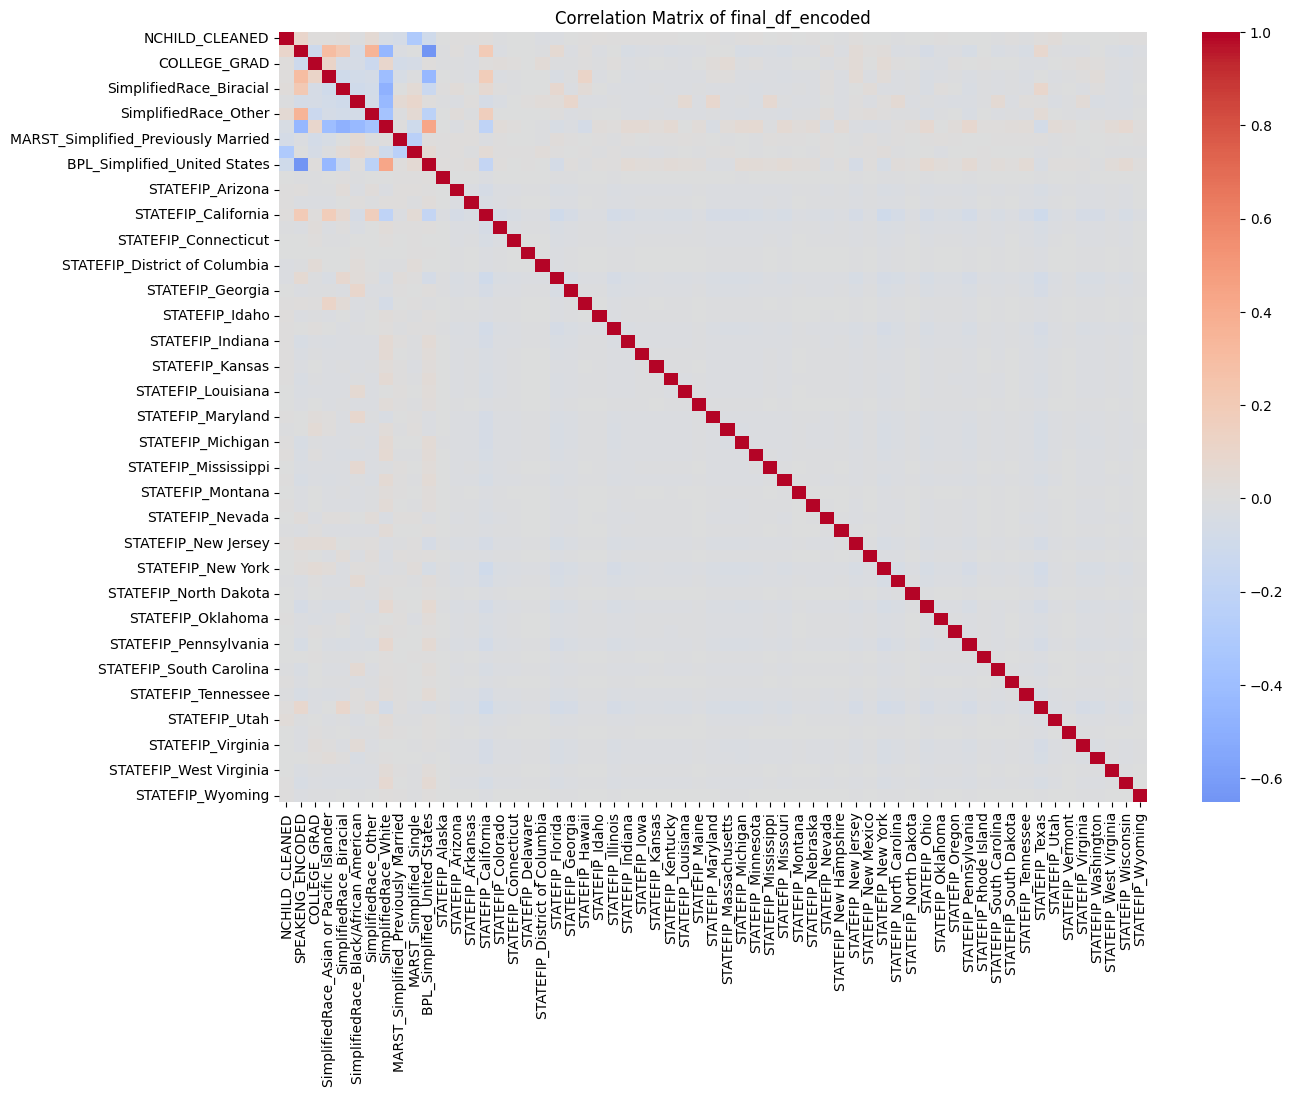

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title("Correlation Matrix of final_df_encoded")
plt.show()

In [30]:
# Define target and features
X = final_df_encoded.drop(columns=['COLLEGE_GRAD'])
y = final_df_encoded['COLLEGE_GRAD']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## RandomForest

Starting with an inital model to get a baseline.

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

print("✅ Accuracy Score:")
print(f"{accuracy_score(y_test, y_pred):.4f}")


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.40      0.49     46694
           1       0.61      0.80      0.69     53779

    accuracy                           0.61    100473
   macro avg       0.62      0.60      0.59    100473
weighted avg       0.62      0.61      0.60    100473

✅ Accuracy Score:
0.6145


In [ ]:
X_train.shape

(401890, 60)

Now doing a randomized search to find the best hyper parameters along with cross validation to ensure better generalization.

📉 Using sample of 40189 rows for tuning instead of 401890
🚀 Starting randomized search...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Search completed in 1.25 minutes

🏆 Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'class_weight': None}
📦 Training final model on full training data...
✅ Training complete in 0.27 minutes

📊 Cross-validating final model on full training set (5-fold)...

📂 Fold 1
F1 Score: 0.6971 | Accuracy: 0.6073 | AUC: 0.6600

📂 Fold 2
F1 Score: 0.6958 | Accuracy: 0.6068 | AUC: 0.6601

📂 Fold 3
F1 Score: 0.6964 | Accuracy: 0.6110 | AUC: 0.6599

📂 Fold 4
F1 Score: 0.6977 | Accuracy: 0.6092 | AUC: 0.6596

📂 Fold 5
F1 Score: 0.6994 | Accuracy: 0.6090 | AUC: 0.6601

✅ Average CV F1: 0.6973
✅ Average CV Accuracy: 0.6086
✅ Average CV AUC: 0.6599

🧪 Final Test Set Performance:
F1 Score: 0.6995
Accuracy: 0.6097
AUC: 0.6589

Classification Report:
              precision    reca

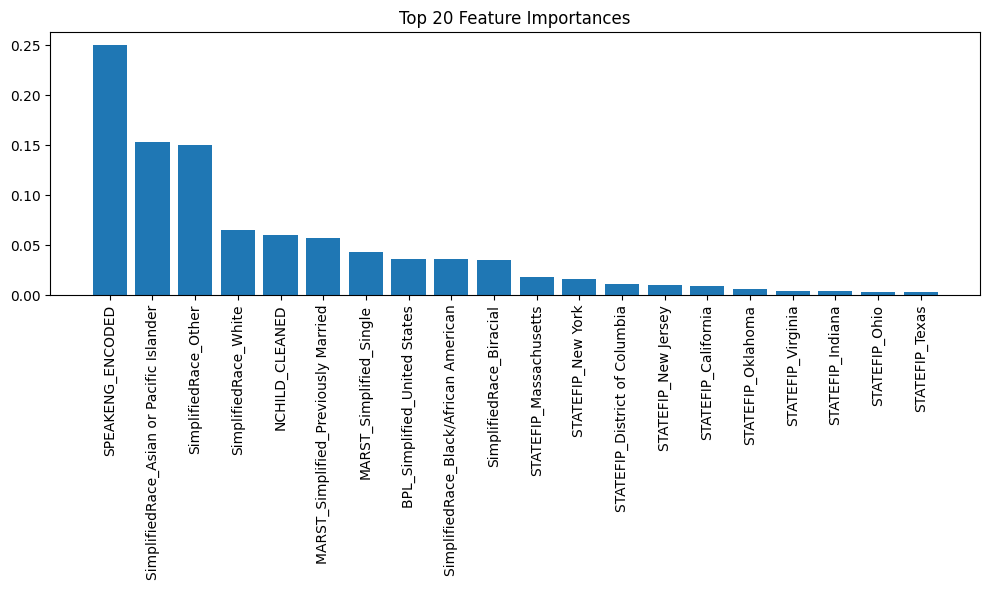

In [ ]:
#Sample a stratified subsample for tuning
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.1,
    stratify=y_train,
    random_state=42
)
print(f"📉 Using sample of {X_sample.shape[0]} rows for tuning instead of {X_train.shape[0]}")

#Define search space
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

#Run Randomized Search with 3-Fold Stratified CV
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=15,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

start_time = time.time()
print("🚀 Starting randomized search...")
random_search.fit(X_sample, y_sample)
print(f"✅ Search completed in {(time.time() - start_time)/60:.2f} minutes")

#Train final model with best parameters
best_params = random_search.best_params_
print("\n🏆 Best Parameters:", best_params)

final_rf = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

print("📦 Training final model on full training data...")
start_time = time.time()
final_rf.fit(X_train, y_train)
print(f"✅ Training complete in {(time.time() - start_time)/60:.2f} minutes")

#Evaluate with 5-Fold Stratified CV
print("\n📊 Cross-validating final model on full training set (5-fold)...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
accuracies = []
aucs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

    final_rf.fit(X_t, y_t)
    y_pred = final_rf.predict(X_v)
    y_proba = final_rf.predict_proba(X_v)[:, 1]

    f1 = f1_score(y_v, y_pred)
    acc = accuracy_score(y_v, y_pred)
    auc = roc_auc_score(y_v, y_proba)

    f1_scores.append(f1)
    accuracies.append(acc)
    aucs.append(auc)

    print(f"\n📂 Fold {fold}")
    print(f"F1 Score: {f1:.4f} | Accuracy: {acc:.4f} | AUC: {auc:.4f}")

print(f"\n✅ Average CV F1: {np.mean(f1_scores):.4f}")
print(f"✅ Average CV Accuracy: {np.mean(accuracies):.4f}")
print(f"✅ Average CV AUC: {np.mean(aucs):.4f}")

# Final Test Set Evaluation
y_test_pred = final_rf.predict(X_test)
y_test_proba = final_rf.predict_proba(X_test)[:, 1]

print("\n🧪 Final Test Set Performance:")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Feature Importance
importances = final_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Top 20 Feature Importances')
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), X_train.columns[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

# we've decided this is the model we want to serialize
joblib.dump(final_rf, 'model.pkl')


Grid search was also done on a small subset however, running it took a very long time. We also found that we got better over all model performance from the random search hyperparameter tuning.

## AdaBoost

In [ ]:
# Initialize AdaBoost with the base estimator
ab = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

# Train on training data
ab.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [ ]:
y_pred = ab.predict(X_test)

# Print classification report
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

# Print accuracy
print("✅ Accuracy Score:")
print(f"{accuracy_score(y_test, y_pred):.4f}")

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.34      0.44     46694
           1       0.59      0.83      0.69     53779

    accuracy                           0.60    100473
   macro avg       0.61      0.59      0.57    100473
weighted avg       0.61      0.60      0.58    100473

✅ Accuracy Score:
0.6033


Using sample of 40189 rows for tuning instead of 401890
Starting randomized search for AdaBoost...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
21 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

Search completed in 0.93 minutes

Best Parameters for AdaBoost: {'n_estimators': 200, 'learning_rate': 0.1, 'algorithm': 'SAMME'}
Training final AdaBoost model on full training data...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Training complete in 1.05 minutes

Cross-validating final Adaboost model on full training set (5-fold)...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Fold 1
F1 Score: 0.7070 | Accuracy: 0.5781 | AUC: 0.6147


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Fold 2
F1 Score: 0.7073 | Accuracy: 0.5784 | AUC: 0.6140


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Fold 3
F1 Score: 0.7087 | Accuracy: 0.5801 | AUC: 0.6156


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Fold 4
F1 Score: 0.7075 | Accuracy: 0.5787 | AUC: 0.6158


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Fold 5
F1 Score: 0.7068 | Accuracy: 0.5773 | AUC: 0.6145

Average CV F1: 0.7074
Average CV Accuracy: 0.5785
Average CV AUC: 0.6149

Final Test Set Performance:
F1 Score: 0.7074
Accuracy: 0.5790
AUC: 0.6145

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.15      0.25     46694
           1       0.56      0.95      0.71     53779

    accuracy                           0.58    100473
   macro avg       0.64      0.55      0.48    100473
weighted avg       0.64      0.58      0.49    100473



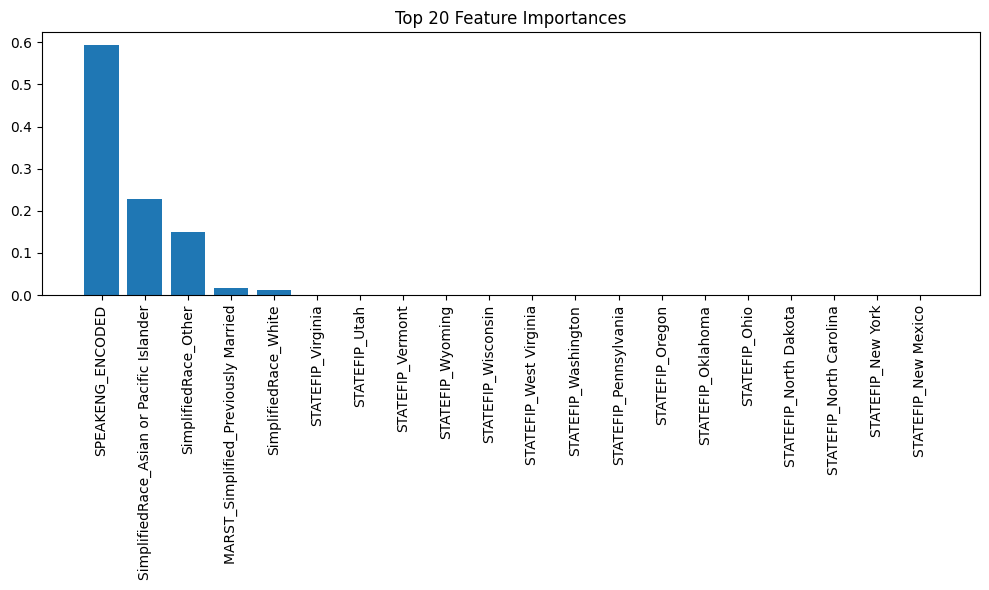

In [ ]:
# ---- Step 1: Sample a stratified subsample for tuning ----

##Utilizing a small sample from the training data makes sure that it does not take
##a long time to search for the best hyperparameters

X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.1,
    stratify=y_train,
    random_state=42
)
print(f"Using sample of {X_sample.shape[0]} rows for tuning instead of {X_train.shape[0]}")

# ---- Step 2: Define search space ----
#AdaBoost also has less parameters to consider than Random Forest and Gradient Boost
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'algorithm': ['SAMME', 'SAMME.R']  # AdaBoost has two algorithm options
}

# ---- Step 3: Run Randomized Search with 3-Fold Stratified CV ----
#Declares the classifier.
ada_boost = AdaBoostClassifier(random_state=42)
## Uses random search to search all of the different combinations from the parameters
## by training on different data sets and cross-validating to check the models performance.
random_search = RandomizedSearchCV(
    estimator=ada_boost,
    param_distributions=param_distributions,
    n_iter=15,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    #Will test 15 different combinations and produces the best F1 score
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

start_time = time.time()
print("Starting randomized search for AdaBoost...")
#Run the random search on the sample data
random_search.fit(X_sample, y_sample)
print(f"Search completed in {(time.time() - start_time)/60:.2f} minutes")

# ---- Step 4: Train final model with best parameters ----
#Store the best parameters from the random search
best_params = random_search.best_params_
print("\nBest Parameters for AdaBoost:", best_params)

#Declare the classifier by using the best parameters from random search
final_ada_boost = AdaBoostClassifier(
    **best_params,
    random_state=42
)

print("Training final AdaBoost model on full training data...")
start_time = time.time()
#Start applying the best parameters to the full extended dataset
final_ada_boost.fit(X_train, y_train)
print(f"Training complete in {(time.time() - start_time)/60:.2f} minutes")

# ---- Step 5: Evaluate with 5-Fold Stratified CV ----
print("\nCross-validating final Adaboost model on full training set (5-fold)...")
#StratifiedKFold splits the data into subsets and randomizes the records so that we can test
#the data efficiently.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
accuracies = []
aucs = []

#Loops through each fold and fits the parameters to it and predicts the value
#Will then calculate f1, accuracy, and auc scores and store them in a list
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

    final_ada_boost.fit(X_t, y_t)
    y_pred = final_ada_boost.predict(X_v)
    y_proba = final_ada_boost.predict_proba(X_v)[:, 1]

    f1 = f1_score(y_v, y_pred)
    acc = accuracy_score(y_v, y_pred)
    auc = roc_auc_score(y_v, y_proba)

    f1_scores.append(f1)
    accuracies.append(acc)
    aucs.append(auc)

    print(f"\nFold {fold}")
    print(f"F1 Score: {f1:.4f} | Accuracy: {acc:.4f} | AUC: {auc:.4f}")
#Average the scores and print tem
print(f"\nAverage CV F1: {np.mean(f1_scores):.4f}")
print(f"Average CV Accuracy: {np.mean(accuracies):.4f}")
print(f"Average CV AUC: {np.mean(aucs):.4f}")

# ---- Step 6: Final Test Set Evaluation ----
#Makes predictions on the Test Data using the trained model.
y_test_pred = final_ada_boost.predict(X_test)
#Calculate the Probability that each prediction is in the positive class
y_test_proba = final_ada_boost.predict_proba(X_test)[:, 1]

print("\nFinal Test Set Performance:")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# ---- Step 7: Feature Importance ----
#Stores the features in order of importance based on the models predictions
importances = final_ada_boost.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Top 20 Feature Importances')
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), X_train.columns[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

Using sample of 20094 rows for tuning instead of 401890
Starting grid search on sample data ((20094, 60))...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

Search completed in 0.66 minutes

Best parameters found:  {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 200}
Training final AdaBoost model on full training data...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Final AdaBoost model training completed in 1.06 minutes

Test set performance:
F1 score: 0.7074
Accuracy: 0.5790
AUC: 0.6144

Top 5 parameter combinations:

Combination 1 (Score: 0.7026):
- algorithm: SAMME
- learning_rate: 0.1
- n_estimators: 200

Combination 2 (Score: 0.7063):
- algorithm: SAMME
- learning_rate: 0.1
- n_estimators: 50

Combination 3 (Score: 0.7063):
- algorithm: SAMME
- learning_rate: 0.2
- n_estimators: 50

Combination 4 (Score: 0.7071):
- algorithm: SAMME
- learning_rate: 0.1
- n_estimators: 100

Combination 5 (Score: 0.7065):
- algorithm: SAMME
- learning_rate: 0.01
- n_estimators: 100


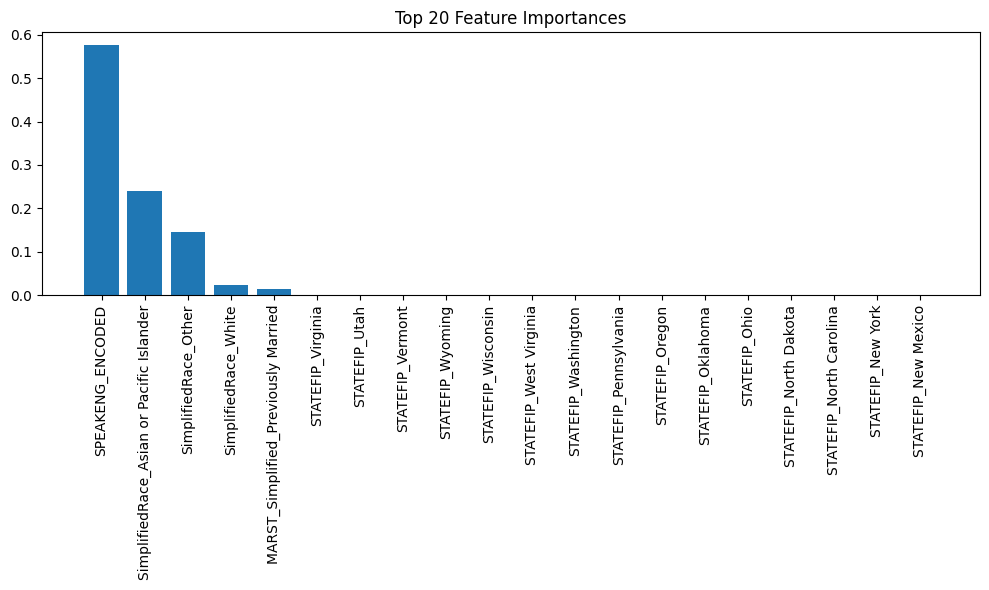

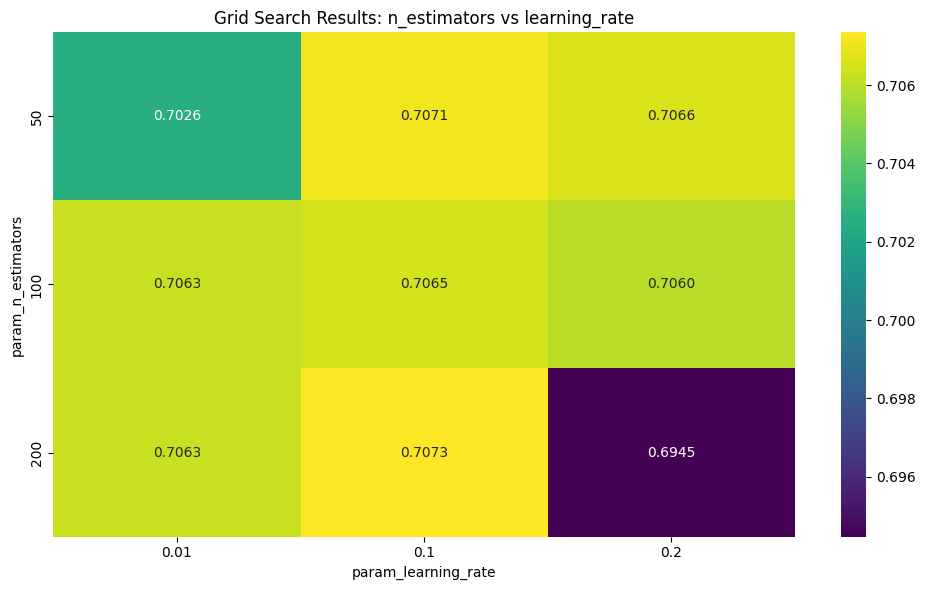

In [ ]:
# Clean the memory to open efficiency and not holding too much information in storage
gc.collect()

# 1. Subsample for hyperparameter tuning
# This is essential for making Grid Search viable with large datasets
#If the data set is not smaller for fine tuning it will take forever with a grid search.
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.05,  # Use just 5% of training data (smaller than before)
    stratify=y_train,
    random_state=42
)

print(f"Using sample of {X_sample.shape[0]} rows for tuning instead of {X_train.shape[0]}")

# 2. Highly focused parameter grid for AdaBoost
#Use the same data as in the first AdaBoost model so that we can compare direct results
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'algorithm': ['SAMME', 'SAMME.R']  # AdaBoost has two algorithm options
}

# 3. Set up Grid Search with minimal CV
#Declare the classifier
ada_boost = AdaBoostClassifier(random_state=42)
#Create the grid search
grid_search = GridSearchCV(
    estimator=ada_boost,
    param_grid=param_grid,
    cv=3,      # Reduced from standard 5 folds to make more efficient
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# 4. Monitor execution time
start_time = time.time()
print(f"Starting grid search on sample data ({X_sample.shape})...")
#Apply the grid search to teh sample set
grid_search.fit(X_sample, y_sample)
print(f"Search completed in {(time.time() - start_time)/60:.2f} minutes")

# 5. Train final model with best parameters on full training data
print("\nBest parameters found: ", grid_search.best_params_)
#Store the best parameters from the grid search
best_params = grid_search.best_params_

# Create the final model with best parameters
final_ada_boost = AdaBoostClassifier(
    **best_params,  # Unpack the best parameters
    random_state=42
)

# Train on full dataset (free memory before this step)
del X_sample, y_sample
gc.collect()

print("Training final AdaBoost model on full training data...")
start_time = time.time()
#Apply the best model to all of the training data
final_ada_boost.fit(X_train, y_train)
print(f"Final AdaBoost model training completed in {(time.time() - start_time)/60:.2f} minutes")

# Evaluate on test set
#Test the model to see how well it predicts the test data
y_pred = final_ada_boost.predict(X_test)
print("\nTest set performance:")
print(f"F1 score: {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, final_ada_boost.predict_proba(X_test)[:, 1]):.4f}")

# Save the results to analyze
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')

# Display top 5 parameter combinations
print("\nTop 5 parameter combinations:")
for i, params in enumerate(results['params'][:5]):
    print(f"\nCombination {i+1} (Score: {results['mean_test_score'][i]:.4f}):")
    for param, value in params.items():
        print(f"- {param}: {value}")

# Feature importance visualization
importances = final_ada_boost.feature_importances_
indices = np.argsort(importances)[::-1]

# Get top 20 features (for readability)
plt.figure(figsize=(10, 6))
plt.title('Top 20 Feature Importances')
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), X_train.columns[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

# Plot the parameter search results for n_estimators and learning_rate
param_scores = results.pivot_table(
    index='param_n_estimators',
    columns='param_learning_rate',
    values='mean_test_score'
)

plt.figure(figsize=(10, 6))
sns.heatmap(param_scores, annot=True, fmt='.4f', cmap='viridis')
plt.title('Grid Search Results: n_estimators vs learning_rate')
plt.tight_layout()
plt.show()


## XGBoost

Using sample of 40189 rows for tuning instead of 401890
Starting randomized search...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:20:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Search completed in 0.57 minutes

Best Parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.01, 'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Training final XGBoost model on full training data...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:20:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training complete in 0.08 minutes

Cross-validating final XGBoost model on full training set (5-fold)...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:20:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Fold 1
F1 Score: 0.7081 | Accuracy: 0.6007 | AUC: 0.6612


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:20:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Fold 2
F1 Score: 0.7078 | Accuracy: 0.6002 | AUC: 0.6614


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:20:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Fold 3
F1 Score: 0.7090 | Accuracy: 0.6023 | AUC: 0.6615


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Fold 4
F1 Score: 0.7087 | Accuracy: 0.6009 | AUC: 0.6605


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:20:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Fold 5
F1 Score: 0.7086 | Accuracy: 0.6027 | AUC: 0.6609

Average CV F1: 0.7084
Average CV Accuracy: 0.6014
Average CV AUC: 0.6611

Final Test Set Performance:
F1 Score: 0.7080
Accuracy: 0.6023
AUC: 0.6597

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.26      0.38     46694
           1       0.58      0.90      0.71     53779

    accuracy                           0.60    100473
   macro avg       0.64      0.58      0.54    100473
weighted avg       0.63      0.60      0.55    100473



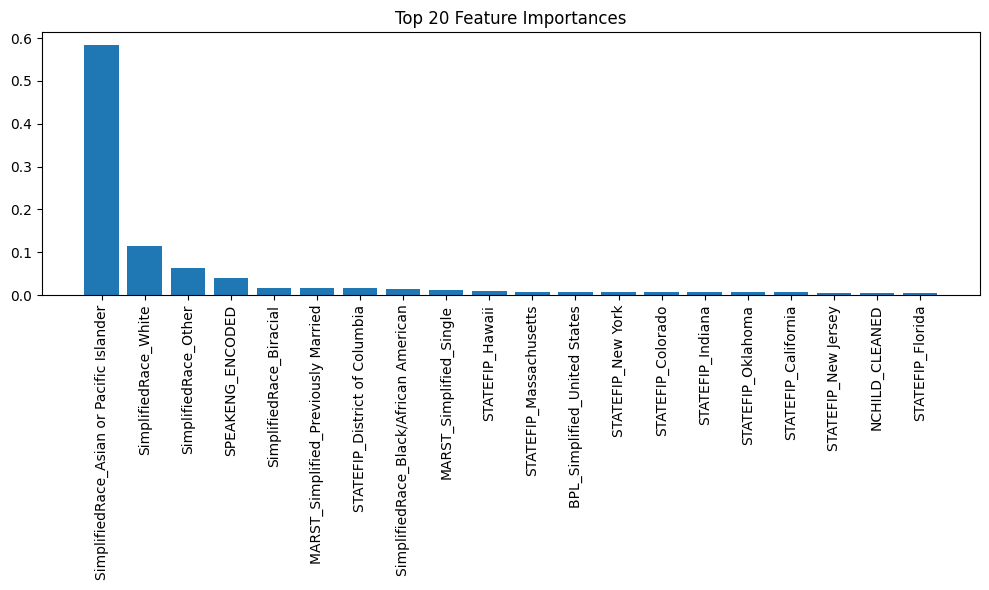

In [ ]:
# *** Takes more than 30 minutes to run ***

# ---- Step 1: Sample a stratified subsample for tuning ----
#Saves time with the model by taking a sample to find the best parameters
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.1,
    stratify=y_train,
    random_state=42
)
print(f"Using sample of {X_sample.shape[0]} rows for tuning instead of {X_train.shape[0]}")

# ---- Step 2: Define search space ----
#Has more parameters than AdaBoost
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.1, 1.0, 10.0]
}

# ---- Step 3: Run Randomized Search with 3-Fold Stratified CV ----
#Declare the XGBoost Classifier without label encoding since it is already encoded
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
#Create the random search parameter with 15 iterations since there are more parameters to go through
#There will also be 3 splits in the folds because the computing power for this model is intense.
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=15,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

start_time = time.time()
print("Starting randomized search...")
#Apply the all settings to the sample to pick the best ones
random_search.fit(X_sample, y_sample)
print(f"Search completed in {(time.time() - start_time)/60:.2f} minutes")

# ---- Step 4: Train final model with best parameters ----
#Drawing out the best parameters
best_params = random_search.best_params_
print("\nBest Parameters:", best_params)
#Declare the best model using the best parameters established earlier
final_xgb = XGBClassifier(
    **best_params,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

print("Training final XGBoost model on full training data...")
start_time = time.time()
#Train the training set using the best model
final_xgb.fit(X_train, y_train)
print(f"Training complete in {(time.time() - start_time)/60:.2f} minutes")

# ---- Step 5: Evaluate with 5-Fold Stratified CV ----
print("\nCross-validating final XGBoost model on full training set (5-fold)...")
#Apply the best model on the 5 folds of the data and calculate the average statistics
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
accuracies = []
aucs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

    final_xgb.fit(X_t, y_t)
    y_pred = final_xgb.predict(X_v)
    y_proba = final_xgb.predict_proba(X_v)[:, 1]

    f1 = f1_score(y_v, y_pred)
    acc = accuracy_score(y_v, y_pred)
    auc = roc_auc_score(y_v, y_proba)

    f1_scores.append(f1)
    accuracies.append(acc)
    aucs.append(auc)

    print(f"\nFold {fold}")
    print(f"F1 Score: {f1:.4f} | Accuracy: {acc:.4f} | AUC: {auc:.4f}")

print(f"\nAverage CV F1: {np.mean(f1_scores):.4f}")
print(f"Average CV Accuracy: {np.mean(accuracies):.4f}")
print(f"Average CV AUC: {np.mean(aucs):.4f}")

# ---- Step 6: Final Test Set Evaluation ----
#Testing the model with data it hasn't seen before
y_test_pred = final_xgb.predict(X_test)
y_test_proba = final_xgb.predict_proba(X_test)[:, 1]

print("\nFinal Test Set Performance:")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# ---- Step 7: Feature Importance ----
#Store the features in a list based on what the model deems as important
importances = final_xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Top 20 Feature Importances')
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), X_train.columns[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Clean up the memory
gc.collect()

# 1. Use a subsample for hyperparameter tuning
# This is essential for making Grid Search viable with large datasets
#Grid search is more intensive so make the dataset smaller
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.05,  # Use just 5% of training data (smaller than before)
    stratify=y_train,
    random_state=42
)

print(f"Using sample of {X_sample.shape[0]} rows for tuning instead of {X_train.shape[0]}")

# 2. Highly focused parameter grid
# Significantly reduced from original to make Grid Search feasible
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.1, 1.0, 10.0]
}

# This grid has 3×3×3×3×3×3×3 = 2187 combinations (still feasible)

# 3. Set up Grid Search with minimal CV
#Declare classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
#Declare the parameters of the gridsearch
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,      # Reduced from standard 5 folds
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# 4. Monitor execution time
start_time = time.time()
print(f"Starting grid search on sample data ({X_sample.shape})...")
#Testing all the settings produced in the grid search against the sample data to find the best settings for the model
grid_search.fit(X_sample, y_sample)
print(f"Search completed in {(time.time() - start_time)/60:.2f} minutes")

# 5. Train final model with best parameters on full training data
print("\nBest parameters found: ", grid_search.best_params_)
#Save the best parameters
best_params = grid_search.best_params_

# Create the final model with best parameters
final_xgb = XGBClassifier(
    **best_params,  # Unpack the best parameters
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

#Freeing the memory before we train the full dataset
del X_sample, y_sample
gc.collect()

print("Training final XGBoost model on full training data...")
start_time = time.time()
#Building the final model using the best parameters
final_xgb.fit(X_train, y_train)
print(f"Final XGBoost model training completed in {(time.time() - start_time)/60:.2f} minutes")

# Evaluate the model by applying it to the test set
y_pred = final_xgb.predict(X_test)
print("\nTest set performance:")
print(f"F1 score: {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, final_xgb.predict_proba(X_test)[:, 1]):.4f}")

# Save the results to analyze
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')

# Display top 5 parameter combinations
print("\nTop 5 parameter combinations:")
for i, params in enumerate(results['params'][:5]):
    print(f"\nCombination {i+1} (Score: {results['mean_test_score'][i]:.4f}):")
    for param, value in params.items():
        print(f"- {param}: {value}")

# Feature importance visualization
importances = final_xgb.feature_importances_
indices = np.argsort(importances)[::-1]

# Get top 20 features (for readability)
plt.figure(figsize=(10, 6))
plt.title('Top 20 Feature Importances')
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), X_train.columns[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

# Plot the parameter search results for n_estimators and max_depth
param_scores = results.pivot_table(
    index='param_n_estimators',
    columns='param_max_depth',
    values='mean_test_score'
)

plt.figure(figsize=(10, 6))
sns.heatmap(param_scores, annot=True, fmt='.4f', cmap='viridis')
plt.title('Grid Search Results: n_estimators vs max_depth')
plt.tight_layout()
plt.show()


Using sample of 20094 rows for tuning instead of 401890
Starting grid search on sample data ((20094, 60))...
Fitting 3 folds for each of 6561 candidates, totalling 19683 fits


## Gradient Boost


In this section, we build a Gradient Boosting model to predict college graduation using engineered features. First, we will create a general GB classifier model without hyperparameters to serve as a baseline for the rest of our modeling.

Training Gradient Boosting model...
Training complete. Took 53.54 seconds.

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.42      0.51     46694
           1       0.61      0.79      0.69     53779

    accuracy                           0.62    100473
   macro avg       0.62      0.60      0.60    100473
weighted avg       0.62      0.62      0.60    100473

F1 Score: 0.6026
Accuracy: 0.6167
Precision: 0.6200
AUC (One-vs-Rest): 0.6612


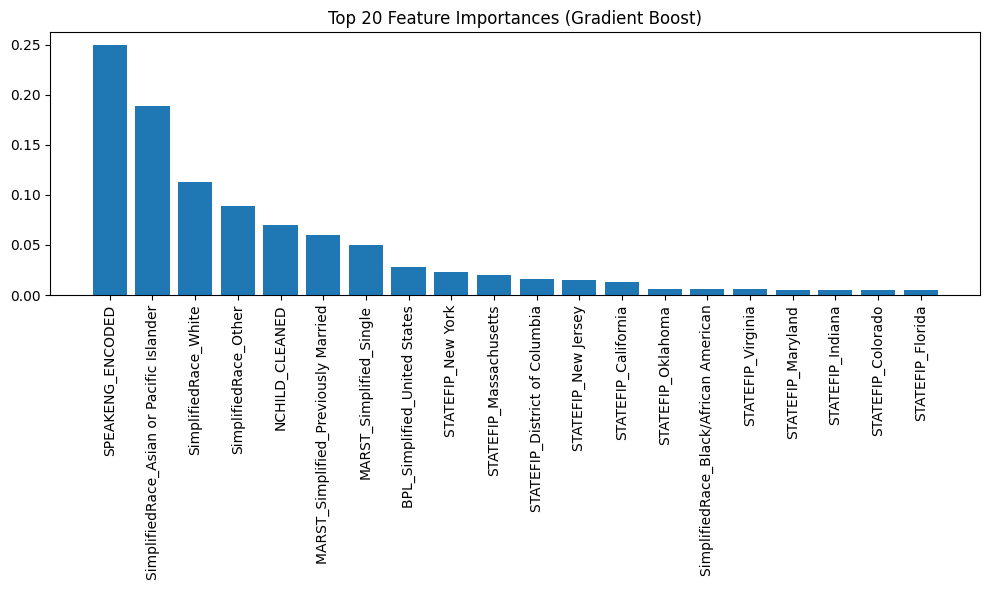

In [31]:

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Train Gradient Boosting Model ---
start = time.time()
print("Training Gradient Boosting model...")
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
print(f"Training complete. Took {round(time.time() - start, 2)} seconds.")

# --- Predict and Evaluate ---
y_pred = gb_model.predict(X_test)
y_proba = gb_model.predict_proba(X_test)
y_test_bin = pd.get_dummies(y_test)

f1 = f1_score(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test_bin, y_proba, average='weighted', multi_class='ovr')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"AUC (One-vs-Rest): {auc:.4f}")

# --- Plot Top 20 Feature Importances ---
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Top 20 Feature Importances (Gradient Boost)')
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), X.columns[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

Per previous models, we will refine the performance by tuning the hyperparameter to conduct GB through a randomized search. See below for that refinement.

Tuning on 40189 rows
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Tuning complete in 3.34 minutes
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.1}

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.48      0.54     46694
           1       0.62      0.75      0.68     53779

    accuracy                           0.62    100473
   macro avg       0.62      0.61      0.61    100473
weighted avg       0.62      0.62      0.61    100473

F1 Score: 0.6146
Accuracy: 0.6221
Precision: 0.6220
AUC: 0.6684


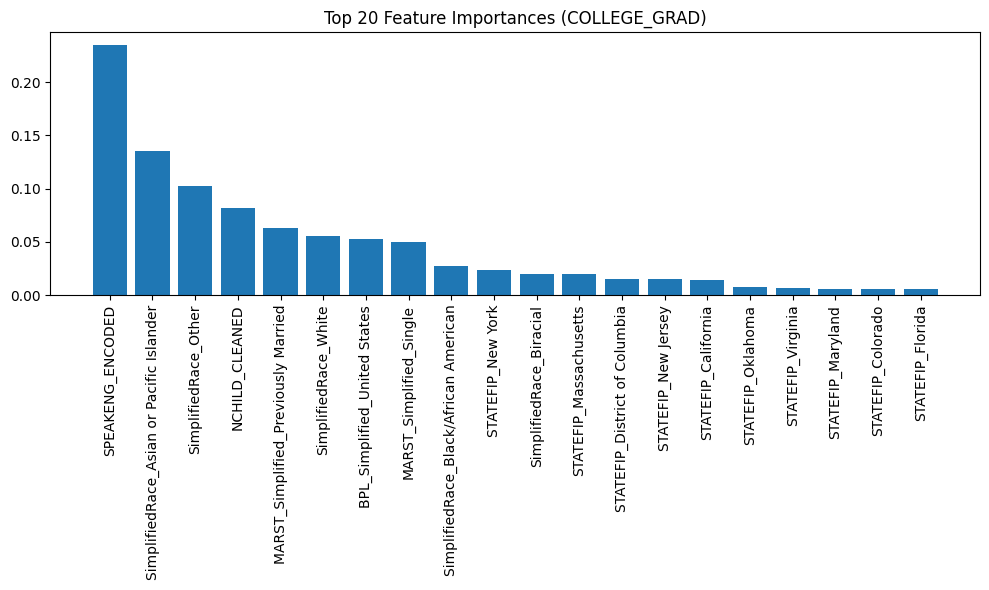

In [32]:


# --- Stratified subsample for tuning ---
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.1,
    stratify=y_train,
    random_state=42
)
print(f"Tuning on {X_sample.shape[0]} rows")

# --- Define parameter grid ---
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=15,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

start = time.time()
search.fit(X_sample, y_sample)
print(f"Tuning complete in {round((time.time() - start) / 60, 2)} minutes")
print("Best Parameters:", search.best_params_)

# --- Train final model on full training data ---
best_gb = GradientBoostingClassifier(**search.best_params_, random_state=42)
best_gb.fit(X_train, y_train)

# --- Final test set evaluation ---
y_pred = best_gb.predict(X_test)
y_proba = best_gb.predict_proba(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba[:, 1]):.4f}")

# --- Feature Importance ---
importances = best_gb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances (COLLEGE_GRAD)")
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), X.columns[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

We refine the Gradient Boosting model using GridSearchCV, while utilizing the best parameters that were found from the randomized search. This allows for more granular tuning and potential performance gains. This model is slower than the previous two, taking at least 15 minutes to run on an M3-based MacBook Air.

In [ ]:

# Use best values as center points
grid_params = {
    'n_estimators': [250, 300, 350],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.9, 1.0],
    'max_features': ['sqrt']  # fixed based on RandomizedSearchCV
}

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=grid_params,
    scoring='f1_weighted',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Train final model using best params
best_gb_grid = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)
best_gb_grid.fit(X_train, y_train)

# Evaluate
y_pred = best_gb_grid.predict(X_test)
y_proba = best_gb_grid.predict_proba(X_test)[:, 1]

print("\nClassification Report (GridSearch):")
print(classification_report(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

We used a Lasso-like regression, or a Logistic Regression model, to supplement our previous analysis. This approach helps validate our domain-based feature selection in the last pre-processing steps by penalizing less informative features. While tree-based models are more efficient at capturing complex relationships, they lack some features of logistic regression with L1 penalty:
- This model helps us identify the most relevant predictors by shrinking less significant feature coefficients to zero.
- Helps us reduce overfitting by penalizing complexity.
- Makes model feature selection easier to explain and justify.

In [33]:

# Fit Lasso Logistic Regression (with CV to tune regularization)
lasso_model = LogisticRegressionCV(
    Cs=10,  # number of inverse regularization strengths to try
    penalty='l1',
    solver='saga',
    scoring='f1',
    max_iter=500,
    cv=5,
    random_state=42,
    n_jobs=-1
)
lasso_model.fit(X_train, y_train)

# Evaluate
y_pred = lasso_model.predict(X_test)
y_proba = lasso_model.predict_proba(X_test)[:, 1]

print("\nClassification Report (Lasso):")
print(classification_report(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Extract non-zero coefficients (important features)
coefs = pd.Series(lasso_model.coef_[0], index=X.columns)
selected_features = coefs[coefs != 0].sort_values(key=abs, ascending=False)

print(f"\nSelected {len(selected_features)} features out of {X.shape[1]}")
print("\nTop 15 Non-Zero Coefficients (Lasso):")
print(selected_features.head(15))


Classification Report (Lasso):
              precision    recall  f1-score   support

           0       0.71      0.11      0.19     46694
           1       0.55      0.96      0.70     53779

    accuracy                           0.56    100473
   macro avg       0.63      0.53      0.45    100473
weighted avg       0.63      0.56      0.46    100473

F1 Score: 0.7028
Accuracy: 0.5648
Precision: 0.5538
AUC: 0.5267

Selected 1 features out of 60

Top 15 Non-Zero Coefficients (Lasso):
SPEAKENG_ENCODED   -0.126288
dtype: float64


The overall accuracy scores for this logistic regression are lower than our previous models, suggesting that the regression traded simplicity for performance. It had extremely high recall, which means it effectively identified positive outcomes, whether or not they were false.

Out of all 60 features, it only selected one as statistically significant, suggesting that English-speaking ability was most directly associated with college graduation in the dataset. The negative association suggests that lower English proficiency also decreases the likelihood of graduating.

This regression model, aimed at diversifying our portfolio of algorithms used for our project, further suggests the need for stronger feature engineering and a more robust dataset that could help strengthen the importance of other features in the future.